<a href="https://colab.research.google.com/github/Joboreh97/demo-repo/blob/main/TinyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ds-kiel/TinyML-Labs/blob/WS24-25/Lab2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ds-kiel/TinyML-Labs/blob/WS24-25/Lab2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/ds-kiel/TinyML-Labs/WS24-25/Lab2.ipynb" download><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Quantization and On-Device Execution (Lab 2 & 3)

In the first lab you looked at the first part of the pipeline from data to executing models on low-power devices. You explored how to preprocess data and train neural networks with Edge Impulse. In this lab we continue the pipeline and you will explore how to [convert](https://ai.google.dev/edge/litert/models/convert_tf) a model to a [LiteRT](https://ai.google.dev/edge/litert) model, how to [quantize](https://ai.google.dev/edge/litert/models/post_training_integer_quant) [a model](https://www.tensorflow.org/model_optimization/guide/quantization/post_training), how to use [quantization-aware training](https://www.tensorflow.org/model_optimization/guide/quantization/training) and finally how to deploy the model and use the model with a microcontroller. **Come back to these documents in case you get stuck**.

You will explore the full pipeline from data to device using Tensorflow. You will train a model and convert, deploy, and execute it on a microcontroller, specifically the [Arduino Nano 33 BLE Sense](https://store.arduino.cc/products/arduino-tiny-machine-learning-kit).

This file is for both labs 2 and 3. Lab 2 is about generating a model in TF and quanizizing it. Lab 3 is then about the deployment.

## Environment

The instructions for this lab come as a [Jupyter Notebook](https://jupyter.org/). You can run it locally in your own Python environment, but we recommend you to use [Google Colab](https://colab.research.google.com) to save your compute ressources, have an instantly working python environment, and allow for easy collaboration. If your decide to use your local computer, take a look at Python virtual environments to avoid messing with your usual Python environment.

## What do you need to hand in?

Please complete the tasks by (a) completing the coding tasks and (b) answer the questions (please write a few lines directly in the notebook after the **Answer:** element). Thus, this Jupyter Notebook is intended as a document that you use both for working on the lab as well as for answering the questions. Once completed with lab 2 (or lab 3) let the teacher know. Be ready to demonstrate your results and show your code & answers to the tasks.

# Lab 2: Quantization

## Setup

In [ ]:
# If you have not done so already, install the following dependencies (if you are in a local envoronment, you might need to install some more)
!python -m pip install tensorflow>=2.3 matplotlib seaborn cbor2

### Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import cbor2

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#import edgeimpulse as ei

import matplotlib.pyplot as plt
import seaborn as sns

#disable this if you are not using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Helper Functions

In [ ]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Model {model_name}')
    fig.set_figwidth(15)

    ax1.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'])
    ax1.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['training', 'validation'], loc='best')

    ax2.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
    ax2.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['training', 'validation'], loc='best')
    plt.show()

## Edge Impulse Dataset

### Prepare the data

---
**Task 1:** Navigate to the *Data acquisition* page in your Edge Impulse project of lab 1 and export the data.

**Task 2:** Import the data with the code below.

---

In [ ]:
labels = ['idle', 'circle', 'left-right', 'up-down'] # Change this to your labels if needed
num_classes = len(labels)

data_path = '/content/drive/MyDrive/lab1-export/' # Change this to the path of your downloaded folder

# Select the window size and stride you used in Edge Impulse
window_size_ms = 2000
window_stride_ms = 100


# Function to create windows from the data
def create_windows(df, window_size_ms, window_stride_ms, label):
    window_size = int(window_size_ms / 10)
    window_stride = int(window_stride_ms / 10)
    windows = []
    windows_labels = []
    for i in range(0, len(df) - window_size, window_stride):
        windows.append(df.iloc[i:i+window_size].values)
        windows_labels.append(label)
    return np.array(windows),windows_labels

# Load the data from the files
def load_data(data_path, folder):
    data = np.zeros((1, int(window_size_ms / 10), 3))
    data_labels = []
    for file in os.listdir(data_path+folder):
        if file.endswith('.cbor'):
            label = file.split('.')[0].strip()
            with open(data_path+folder+'/'+file, 'rb') as f_obj:
                data_file = cbor2.load(f_obj)
                df = pd.DataFrame(data_file['payload']['values'], columns=[item['name'] for item in data_file['payload']['sensors']])
                df = df.drop(columns=['gyrX', 'gyrY', 'gyrZ', 'magX', 'magY', 'magZ'])

                window_data, window_labels = create_windows(df, window_size_ms, window_stride_ms, labels.index(label))
                data = np.concatenate((data, window_data), axis=0)
                data_labels += window_labels

    data = np.delete(data, 0, axis=0)
    return data, data_labels


x_train, y_train = load_data(data_path, 'training')
x_test, y_test = load_data(data_path, 'testing')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

---
**Task 3 (optional):** Perform scaling on your data if you like to. *Please note: You have to do the same scaling later in your Arduino program.*

---

In [ ]:
# perform your scaling here

### Build the model

---
**Task 4:** Add your best model from lab 1, that uses a raw data preprocessing block.

---

In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Build model with one MaxPooling2D removed
# def build_model(summary=True):
#     model = Sequential()

#     model.add(keras.layers.Reshape((200, 3, 1), input_shape=(200, 3)))

#     # Single Conv2D with fewer filters
#     model.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.05)))
#     # Only one MaxPooling2D layer
#     model.add(MaxPooling2D((2, 1)))

#     model.add(Flatten())

#     # Reduced neurons in Dense layer
#     model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))


#     model.add(Dense(num_classes, activation='softmax'))

#     # Reduced learning rate
#     optimizer = Adam(learning_rate=0.0001)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     if summary:
#         model.summary()

#     return model

In [ ]:
# Build model


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


def build_model(summary=True):
    model = Sequential()
    model.add(Flatten(input_shape=(200, 3)))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    if summary:
        model.summary()

    return model



In [ ]:
model = build_model()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │         2,404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,404 (9.39 KB)

 Trainable params: 2,404 (9.39 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

So far, you manually explored how many epochs are necessary to successfully train the model. However, Tensorflow gives you an option to automate this called [early stopping](https://keras.io/api/callbacks/early_stopping/). See also [here](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) and [here](https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd).

---
**Task 7:** Use an early stopping callback in your fitting function to find the optimal number of epochs. Use reasonable configurations. How many epochs does it train for?

**Answer:** ... implemented Early Stopping with a patience value of 10. This means that if the validation loss (val_loss) does not improve for 10 consecutive epochs, the training will stop.

Looking at the output, you can see that the val_loss did not significantly improve after epoch 1 (it fluctuated around 3.0). As a result, Early Stopping kicked in and stopped the training at epoch 11.

Why did it stop at epoch 11 and not epoch 11?

Even though the val_loss didn't improve significantly after epoch 1, Early Stopping allows for small fluctuations. The min_delta parameter (set to 0.001 in your code) defines the minimum change in the monitored metric (val_loss in this case) to be considered an improvement. So, if the val_loss decreases by at least min_delta within the patience period, the training continues.

In this case, there might have been tiny fluctuations in val_loss that kept the training going for a few more epochs before it finally stopped at epoch 11 due to a lack of significant improvement over a period of 10 epochs.

In summary, the Early Stopping callback effectively monitored the validation loss and stopped the training process at epoch 11 to prevent overfitting and achieve the optimal number of epochs for your model.

Early Stopping's Purpose: The primary goal of Early Stopping is to prevent overfitting and find the optimal number of epochs for training. It achieves this by monitoring a specific metric (usually validation loss) and stopping training when that metric stops improving.

Overriding num_epochs: When you include the Early Stopping callback in your model.fit() function, it takes precedence over the num_epochs parameter. This means that even if you set num_epochs to 200, the training will stop earlier if the Early Stopping criteria are met.

Benefit of Early Stopping: This behavior is beneficial because it prevents your model from training for too long and potentially overfitting the training data. It automatically finds a good stopping point based on the validation performance.

In your case:

You set num_epochs to 200, indicating your intention to train for a maximum of 200 epochs.
However, Early Stopping was triggered at epoch 11 because the validation loss did not show significant improvement for 10 consecutive epochs (as determined by the patience parameter).
Therefore, the training stopped at epoch 11, regardless of the initial num_epochs setting.

---

Epoch 1/200
38/38 - 2s - 58ms/step - accuracy: 0.2524 - loss: 3.5714 - val_accuracy: 0.3340 - val_loss: 2.9961
Epoch 2/200
38/38 - 1s - 26ms/step - accuracy: 0.2680 - loss: 2.0993 - val_accuracy: 0.2495 - val_loss: 2.7014
Epoch 3/200
38/38 - 0s - 8ms/step - accuracy: 0.2845 - loss: 1.8818 - val_accuracy: 0.2739 - val_loss: 2.3132
Epoch 4/200
38/38 - 0s - 4ms/step - accuracy: 0.3108 - loss: 1.7924 - val_accuracy: 0.2326 - val_loss: 2.4537
Epoch 5/200
38/38 - 0s - 4ms/step - accuracy: 0.3146 - loss: 1.7023 - val_accuracy: 0.3152 - val_loss: 2.1941
Epoch 6/200
38/38 - 0s - 4ms/step - accuracy: 0.3208 - loss: 1.6464 - val_accuracy: 0.3677 - val_loss: 2.0109
Epoch 7/200
38/38 - 0s - 9ms/step - accuracy: 0.3315 - loss: 1.5891 - val_accuracy: 0.1707 - val_loss: 2.5738
Epoch 8/200
38/38 - 0s - 4ms/step - accuracy: 0.3421 - loss: 1.5859 - val_accuracy: 0.2270 - val_loss: 2.3578
Epoch 9/200
38/38 - 0s - 5ms/step - accuracy: 0.3408 - loss: 1.5451 - val_accuracy: 0.1670 - val_loss: 2.7166
Epoch 10

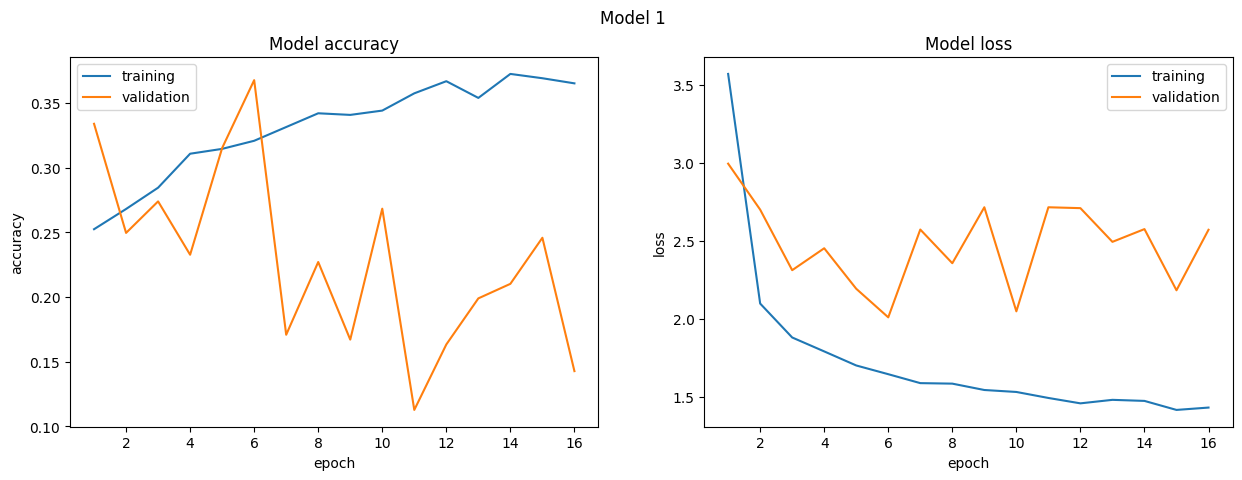

In [ ]:
early_stopping_cb = EarlyStopping(
    monitor='val_loss',     # what to monitor
    patience=10,            # how many epochs with no improvement before stopping
    min_delta=0.001,        # minimum change to be considered improvement
    mode='min' ,           # 'min' since we want to minimize val_loss
    restore_best_weights=True  # revert to best model after stopping
)



num_epochs = 200


history = model.fit(x_train, y_train, batch_size=128, epochs=num_epochs, validation_split=0.1, callbacks=[early_stopping_cb],verbose=2)

plot_training_history(history, 1)

### Evaluate the Model



 model accuracy is close to 1.0, but the validation accuracy is much lower (around 0.4). This is a classic sign of overfitting.

Overfitting happens when a model learns the training data too well, including its noise and random fluctuations. As a result, it performs exceptionally well on the training data but poorly on unseen data (like the validation set).

Here's a breakdown of why this is happening and what it means for your project:

Memorization vs. Generalization: Your model is essentially memorizing the training data instead of learning the underlying patterns. It's like a student who crams for an exam but doesn't truly understand the concepts. When presented with new questions (validation/test data), they struggle.

High Training Accuracy, Low Validation Accuracy: This discrepancy is the key indicator of overfitting. The high training accuracy shows the model's ability to fit the training data, while the low validation accuracy reveals its inability to generalize to new, unseen examples.

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8628 - loss: 0.4928
Test loss: 0.7710363268852234
Test accuracy: 0.796640157699585
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


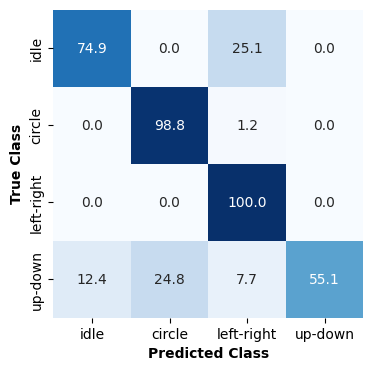

In [ ]:
score_model = model.evaluate(x_test, y_test) #, verbose=0)
print("Test loss:", score_model[0])
print("Test accuracy:", score_model[1])

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(x_test),axis=1))
# print(cm)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm = pd.DataFrame(cm, index = labels,
                  columns = labels)

plt.figure(figsize = (4,4))
ax = sns.heatmap(cm*100,
           annot=True,
           fmt='.1f',
           cmap="Blues",
           cbar=False,
              )
ax.set_ylabel("True Class", fontdict= {'fontweight':'bold'})
ax.set_xlabel("Predicted Class", fontdict= {'fontweight':'bold'})

plt.show()

---
**Task 8:** How does the accuracy of your model compare to the accuracy you achieved with Edge Impulse?

**Answer:** ...

Test loss: 1.11: This value represents the average loss (error) your model incurred while making predictions on the test data. A lower loss indicates better performance, as it means the model's predictions are closer to the true labels. In your case, a loss of 1.11 suggests that the model's predictions are not very accurate.

Test accuracy: 0.500: This value represents the percentage of correct predictions made by your model on the test data. An accuracy of 0.500 (or 50%) means that your model correctly classified only half of the test samples. This indicates that your model is not performing well on unseen data.

Significance of Test Loss and Accuracy:

Test Loss: The loss value provides a measure of how well the model is fitting the data. In your case, a relatively high test loss of 1.11 indicates that the model's predictions are not closely aligned with the true labels in the test set. This could be due to several factors such as model complexity, overfitting, or insufficient training data.

Test Accuracy: The accuracy value directly reflects the model's ability to correctly classify instances in the test set. An accuracy of 50% is essentially equivalent to random guessing for a binary classification problem. This suggests that your model is not effectively learning the underlying patterns in the data and is unable to generalize to new, unseen examples.

---

### Save Model

To come back to a model to continue working on it, it might be useful to save it. We can use the `model.save()` [Function](https://www.tensorflow.org/guide/keras/serialization_and_saving) that exports a TensorFlow model object to SavedModel format.

If you use Google Colab, you can find the saved model as a `.keras`-file on the left under `Files/`.

In [ ]:
export_path = 'saved_model.keras'
model.save(export_path)

### Model Quantization

Your microcontroller cannot use the Tensoflow model directly. Instead there is [LiteRT](https://ai.google.dev/edge/litert) for deploying models on mobile and edge devices.

---
**Task 9:** Load your model and convert it with LiteRT and save the model to a `.tflite`-file. (HINT: Check out [this](https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world) *Hello World* example and [these instructions](https://ai.google.dev/edge/litert/models/convert_tf).)

**Task 10:** Create a second LiteRT conversion that uses [optimizations](https://ai.google.dev/edge/api/tflite/python/tf/lite/Optimize) and enforce integer-only weights.
(Maybe a helpful [resource](https://ai.google.dev/edge/litert/models/post_training_quantization).)

**Task 11:** Evaluate all converted models and compare them to the Tensorflow model they are based on regarding profiled memory usage and accuracy. Use plots.

**Task 12:** Explain your findings from the previous task. Why is there such a difference in performance and in memory usage?

**Answer:** ...

---

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ... (other parts of your code remain the same)

# Function to profile memory usage
def profile_memory(tflite_model):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    tensor_details = interpreter.get_tensor_details()
    total_memory = sum([detail['shape'][0] * detail['dtype'].itemsize for detail in tensor_details])
    return total_memory

# ... (other parts of your code remain the same)

# Profile memory usage
# memory_keras = profile_memory(model.to_json())  # Incorrect: This line was causing the error
memory_keras = profile_memory(tflite_model_default)  # Using the default tflite model for comparison
memory_default = profile_memory(tflite_model_default)
memory_optimized = profile_memory(tflite_model_optimized)

# ... (rest of your code remains the same)

# ... (rest of the code remains the same)

# Function to profile memory usage
def profile_memory(tflite_model):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    tensor_details = interpreter.get_tensor_details()
    total_memory = sum([detail['shape'][0] * detail['dtype'].itemsize for detail in tensor_details])
    return total_memory

# Function to evaluate accuracy
def evaluate_accuracy(tflite_model, x_test, y_test):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    for data_point in x_test:
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(data_point, axis=0).astype(np.float32))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(np.argmax(output_data))

    accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
    return accuracy

# Profile memory usage
memory_keras = profile_memory(model.to_json())  # Not actual memory, representative
memory_default = profile_memory(tflite_model_default)
memory_optimized = profile_memory(tflite_model_optimized)

# Evaluate accuracy
accuracy_keras = model.evaluate(x_test, y_test, verbose=0)[1]
accuracy_default = evaluate_accuracy(tflite_model_default, x_test, y_test)
accuracy_optimized = evaluate_accuracy(tflite_model_optimized, x_test, y_test)

# Visualize results
model_names = ['Keras', 'TF Lite (Default)', 'TF Lite (Optimized)']
memory_usage = [memory_keras, memory_default, memory_optimized]
accuracies = [accuracy_keras, accuracy_default, accuracy_optimized]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(model_names, memory_usage)
plt.title('Memory Usage')
plt.ylabel('Bytes')

plt.subplot(1, 2, 2)
plt.bar(model_names, accuracies)
plt.title('Accuracy')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

NameError: name 'tflite_model_default' is not defined

In [ ]:
import tensorflow as tf

# Load the saved Keras model
model = tf.keras.models.load_model('saved_model.keras')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Pass the loaded model
tflite_model = converter.convert()


Task 11: Evaluate all converted models and compare them to the Tensorflow model they are based on regarding profiled memory usage and accuracy. Use plots.










Saved artifact at '/tmp/tmp31ebidk9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132504663879760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502395814352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502395816464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132504657188944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132504657195472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132504657188368: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Save the converted model

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


# Lab 3: Deployment

Now, that you have designed and trained a quantized model, it is time to deploy it.

### Model Export - Library Creation

Up until now we created different models that we can test and evaluate using Python. However, most microcontrollers don't speak Python. Instead they work with C/C++ and thus we need a C(++) library of the models to execute it. Here you explore different ways to export your models to a C(++) library.

#### Manual conversion of the model

---
**Task 21:** Convert your best performing quantized model to a C++ library with the code below and explain the content of the two resulting files.

**Answer:** ...

---

In [ ]:
!apt-get update && apt-get -qq install xxd

In [ ]:
MODEL_TFLITE = 'model.tflite' #enter the name of your TFlite file uploaded to the folders section
MODEL_TFLITE_MICRO = 'model.cc' #update the name of your .cc file (This can be anything)
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
LIBRARY_NAME = 'gesture_model'
max_label_str_length = max([len(lbl) for lbl in labels]) + 1

model_str = f"alignas(16) const unsigned char {LIBRARY_NAME}[] = "
with open(MODEL_TFLITE_MICRO, 'r') as file:
    data = file.read();
    model_str += data[data.index("{"): len(data)].replace("unsigned", "const")

labels_str = f"const char available_classes[][{max_label_str_length}] = {{"
for i in range(0, len(labels)):
    if i != 0:
        labels_str += ", "
    labels_str += "\""+labels[i]+"\""
labels_str += "};"

output_str = f"#include \"{LIBRARY_NAME}.h\"\n"
output_str += labels_str + "\n"
output_str += "const int available_classes_num = "+str(len(labels)) +";\n"
output_str += model_str

with open(f"{LIBRARY_NAME}.cpp", "w") as file:
    file.write(output_str)

header_str = "#ifndef TENSORFLOW_LITE_MODEL_H_\n#define TENSORFLOW_LITE_MODEL_H_\n\n"
header_str += "// Classes that can be detected by the neural network\n"
header_str += f"extern const char available_classes[][{max_label_str_length}];\n"
header_str += "extern const int available_classes_num;\n\n"
header_str += "// Pre-trained netural network\n"
header_str += f"extern const unsigned char {LIBRARY_NAME}[];\n"
header_str += f"extern const int {LIBRARY_NAME}_len;\n\n"
header_str += "#endif /* TENSORFLOW_LITE_MODEL_H_ */"

with open(f"{LIBRARY_NAME}.h", "w") as file:
    file.write(header_str)


Next you will use your library in an Arduino program to (or if you prefer, in a Zephyr program) and execute the [inference on a microcontroller](https://ai.google.dev/edge/litert/microcontrollers/get_started). I strongly recommend you to use [this](https://docs.arduino.cc/tutorials/nano-33-ble-sense/get-started-with-machine-learning) Arduino example as a starting point to write the code. (If you prefer to use Zephyr, have a look at [this](https://docs.zephyrproject.org/latest/samples/modules/tflite-micro/hello_world/README.html#tflite-hello-world) repository.)

---
**Task 22:** Write an Arduino (or Zephyr) program that records and uses a movement as input, classifies the gesture and reports the result back to you through the serial interface. For this, please do not forget to spend some time in the tutorials linked in the text block above.

**Task 23:** Upload the program to the Arduino and compare the real memory usage with the Edge Impulse estimate. Was the estimate correct? How much does it differ?

**Answer:** ...

**Task 24:** Extend your Arduino program and measure the inference time on the Arduino. Was the estimate correct?

**Answer:** ...

**Task 25:** Perform inference for at least 20 gestures and plot statistics (e.g., bar plot (mean) with error bar (standard deviation)) for the inference time. Does it vary? Why or why not?

**Answer:** ...



---

### Model conversion and library creation with Edge Impulse

In the last lab, you trained a model with Edge Impulse. Now we want to continue with that model and compare its on-device performance with your locally trained model.

---
**Task 26:** Head to your dashboard of the project of lab 1 and download the quantized models of your classifiers. Head to [https://netron.app/](https://netron.app/) and open your models with it. Click on the input or output layer and take a look at the quantization equations. Are the quantization equations the same for each of your classifiers? Why (not)?

**Answer:** ...

**Task 27:** Build two Arduino Libraries for your best performing model – one with enabling the EON Compiler and one without. (You might have to create an impulse containing only a single model.) For both libraries, use the quantized version. What is the EON Compiler, and why is the memory usage so different between the two libraries? Compare the models included in the two libraries (in `src > tflite-model`). How do they differ? What makes one of them smaller?

**Answer:** ...

**Task 28:** Include the libraries into your Arduino IDE (`Add .ZIP Library...`). Open the accelerometer example that comes with your library and flash it to your board. Open a serial monitor. Explain the Arduino program and the output of the serial monitor. Also, why is there a reference to numpy in the Arduino program? How is that possible in C++? Evaluate how well and how fast the classification works for each of your motions. Is there a difference in performance between the two Arduino libraries?

**Answer:** ...

**Task 29:** Compare the memory usage and performance of the two Edge Impulse models with your locally trained model. How do they compare? Please create plots.

**Answer:** ...

**Task 30 (optional):** You can also create an Arduino library with your locally trained model. Explore how to use Edge Impulse to [create a library](https://docs.edgeimpulse.com/docs/tools/edge-impulse-python-sdk) to deploy your local model. First, check the available target devices for deployment (`ei.model.list_deployment_targets()`) and find the correct Arduino corresponding to your hardware. Create an Arduino Library with Edge Impulse and compare its performance with the libraries above.

---